In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b329039fa5b6a51c48478ade21391d83ffbb0be7bf31d55287a80cfbca16ddf13669c14a278682edffa293f4ccda8a7e864ea8f2f1dec12c5b863e99eeac0b4c",overwrite=True)

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
# from qiskit_ibm_provider import IBMProvider
# import qiskit_ibm_provider.jupyter
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

In [3]:
import numpy as np
import qiskit
from qiskit import *
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
# from qiskit.providers.fake_provider import *
# from qiskit_aer.pulse import *
from qiskit.providers import *

import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import train_test_split

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate, QuantumRegister
from qiskit import schedule

# from qiskit.tools.monitor import job_monitor

# from qiskit.tools.jupyter import *
%matplotlib inline

# from qiskit import IBMQ
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
# import qiskit_ibm_provider.jupyter
# IBMProvider.save_account(token=<INSERT_IBM_QUANTUM_TOKEN>)
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

pi = math.pi

/var/folders/h3/mc63pl7x7kb9s61dxd7795jc0000gn/T/ipykernel_8664/46574987.py:28: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  import qiskit_ibm_provider


In [4]:
def n_hop_neighbors (victim, n_hop):
    backend = provider.get_backend(backend_name)
    coupling_map = backend.configuration().coupling_map
    qubits_at_distance_n = []

    for qubit_pair in coupling_map:
        for qubit in qubit_pair:
            if backend.coupling_map.distance(qubit,victim) == n_hop:
                qubits_at_distance_n.append(qubit)

    qubits_at_distance_n = list(set(qubits_at_distance_n))
    return qubits_at_distance_n

In [5]:
victim = 0
# attacker = n_hop_neighbors(victim, 1)
# n_att = np.size(attacker)
# n_hop_neighbors(victim, 4)

In [6]:
default_qubit_freq = backend_defaults.qubit_freq_est[victim] # Default qubit frequency in Hz. 
print(f"Victim has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

Victim has an estimated frequency of 4.721903319753299 GHz.


In [7]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 200) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[0] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, 0] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [8]:
duration = 160
sigma = 40

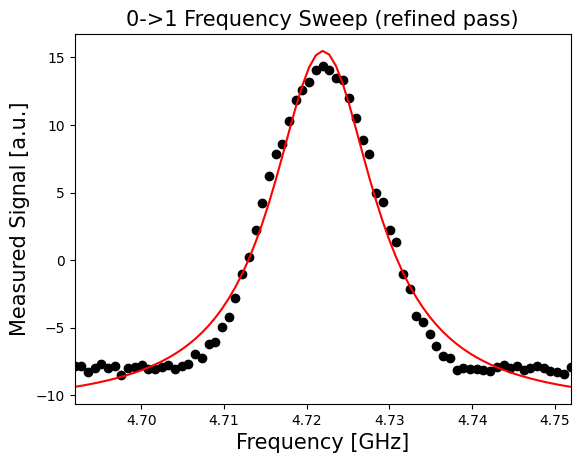

Our updated estimate for the 0->1 transition frequency is 4.7219426 GHz.


In [9]:
# frequency sweep

num_freqs = 75
drive_power = 0.15
######################################################
############## [-10 MHz, 10 MHz] for qubit 70, [-30, 30] for other qubits ################
sweep_freqs = np.linspace(-30*MHz, 30*MHz, num_freqs)


freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq_sweep_sched:
    drive_chan = pulse.drive_channel(victim)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=duration,
                                  amp=drive_power,
                                  sigma=sigma,
                                  name='x_pulse'), drive_chan)

spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(127, 1)

qc_spect.append(spect_gate, [victim])
qc_spect.measure(victim, 0)
qc_spect.add_calibration(spect_gate, (victim,), freq_sweep_sched, [freq])
    
exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

# freq_sweep_job = backend.run(exp_spect_circs, 
#                                      meas_level=1, 
#                                      meas_return='avg', 
#                                      shots=NUM_SHOTS)

# job_monitor(freq_sweep_job)


# ## victim =1
# job_id = "ctj1k7m6g3rg0086rmyg"
# freq_sweep_job = service.job(job_id)

# no default, [-30, 30]
# victim = 0
job_id = "csr3tfh0c2pg008cwdh0"
freq_sweep_job = service.job(job_id)

# ### victim = 64
# job_id = "csr5san0c2pg008cwv4g"
# freq_sweep_job = service.job(job_id)

# # ### victim = 8
# job_id = "csr7r2gvnxy0008e902g"
# freq_sweep_job = service.job(job_id)

# ## victim = 13
# job_id = "csr7spyvnxy0008e90hg"
# freq_sweep_job = service.job(job_id)

# ### victim = 56
# job_id = "csr7sexea560008gb440"
# freq_sweep_job = service.job(job_id)

# # ### victim = 70
# ## [-30, 30]
# # job_id = "csr9v9nvwqp0008bynyg"
# # freq_sweep_job = service.job(job_id)
##[-10, 10]
# job_id = "ct2736cm96kg00876egg"
# freq_sweep_job = service.job(job_id)

# ### victim = 113
# job_id = "csr9vqep1vzg008b7kxg"
# freq_sweep_job = service.job(job_id)

# ### victim = 118
# job_id = "csr9w0gea560008gbkpg"
# freq_sweep_job = service.job(job_id)

# ### victim = 126
# job_id = "csrdhdn1k2e0008q2rpg"
# freq_sweep_job = service.job(job_id)

# Get the refined data (average)
# plot and fit the refined signal, using the standard Lorentzian curve.
freq_sweep_data = get_job_data(freq_sweep_job, average=True)
######################################################
############## [-10 MHz, 10 MHz] for qubit 70, [-30, 30] for other qubits ################
sweep_freqs = default_qubit_freq + np.linspace(-30*MHz, 30*MHz, num_freqs)

def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# # do fit in Hz
(sweep_fit_params, 
 sweep_y_fit) = fit_function(sweep_freqs,
                                     freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.721903319753299*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit based on the estimated frequency
                                     )

# Note: we are only plotting the real part of the signal
plt.scatter(sweep_freqs/GHz, freq_sweep_data, color='black')
plt.plot(sweep_freqs/GHz, sweep_y_fit, color='red')
plt.xlim([min(sweep_freqs/GHz), max(sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep (refined pass)", fontsize=15)
plt.show()
# plt.savefig('DATA frequency sweep.pdf')

_, qubit_freq, _, _ = sweep_fit_params
print(f"Our updated estimate for the 0->1 transition frequency is "
      f"{round(qubit_freq/GHz, 7)} GHz.")

In [10]:
# Rabi Experiment
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(victim)
    pulse.set_frequency(qubit_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=duration,
                              amp=amp,
                              sigma=sigma,
                              name='x_pulse'), drive_chan)
    
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(127, 1)

qc_rabi.append(rabi_gate, [victim])
qc_rabi.measure(victim, 0)
qc_rabi.add_calibration(rabi_gate, (victim,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

# rabi_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=NUM_SHOTS)

# job_monitor(rabi_job)

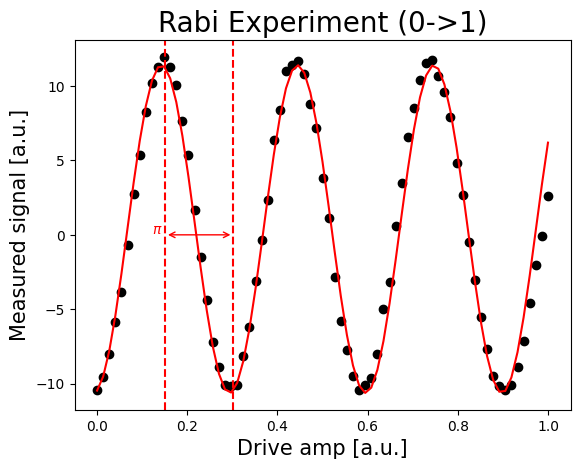

Our updated estimate for the 0->1 transition frequency is 4.7219426 GHz.
Pi Amplitude (0->1) = 0.15099912162198975


In [11]:
# # ## Get the job data (average)
# # victim = 1
# job_id = "ctj1kvqx7b5g008zvtgg"
# rabi_job = service.job(job_id)

### victim = 0
job_id = "csr4n8dvnxy0008e897g"
rabi_job = service.job(job_id)

# ### victim = 64
# job_id = "csr5w8sea560008garmg"
# rabi_job = service.job(job_id)

# # ### victim = 8
# job_id = "csr9ms31k2e0008q1z7g"
# rabi_job = service.job(job_id)

# ### victim = 13
# job_id = "csr9ngeea560008gbjf0"
# rabi_job = service.job(job_id)

# ### victim = 56
# job_id = "csr9pptea560008gbjm0"
# rabi_job = service.job(job_id)

## victim = 70
# ## [-10, 10]
# job_id = "ct29btq7srd0008884k0"
# rabi_job = service.job(job_id)

# ### victim = 113
# job_id = "csrdjzbea560008gcdz0"
# rabi_job = service.job(job_id)

# ### victim = 118
# job_id = "csrdke51k2e0008q2s00"
# rabi_job = service.job(job_id)

# ### victim = 126
# job_id = "ct65s14wmw20008w4m70"
# rabi_job = service.job(job_id)


rabi_data = get_job_data(rabi_job, average=True)

def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

# Note: Only real part of data is plotted
rabi_data = np.real(baseline_remove(rabi_data))
(rabi_fit_params, 
 rabi_y_fit) = fit_function(drive_amps,
                               rabi_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [30, 0, 0.3, 0])
                            

plt.scatter(drive_amps, rabi_data, color='black')
plt.plot(drive_amps, rabi_y_fit, color='red')

drive_period = rabi_fit_params[2] 

pi_amp = drive_period/2

plt.axvline(pi_amp, color='red', linestyle='--')
plt.axvline(pi_amp+drive_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp+drive_period/2, 0), xytext=(pi_amp,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (0->1)', fontsize=20)
plt.show()

print(f"Our updated estimate for the 0->1 transition frequency is "
      f"{round(qubit_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (0->1) = {pi_amp}")

In [12]:
with pulse.build(backend=backend, default_alignment='sequential', name='schedule') as sched:
    drive_chan = pulse.drive_channel(1)
    pulse.set_frequency(qubit_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration,
                              pi_amp,
                              sigma,
                              name='pulse'), drive_chan)
    
custom_gate = Gate("pulse", 1, [])

In [77]:
# n_hop_neighbors(victim, 11)

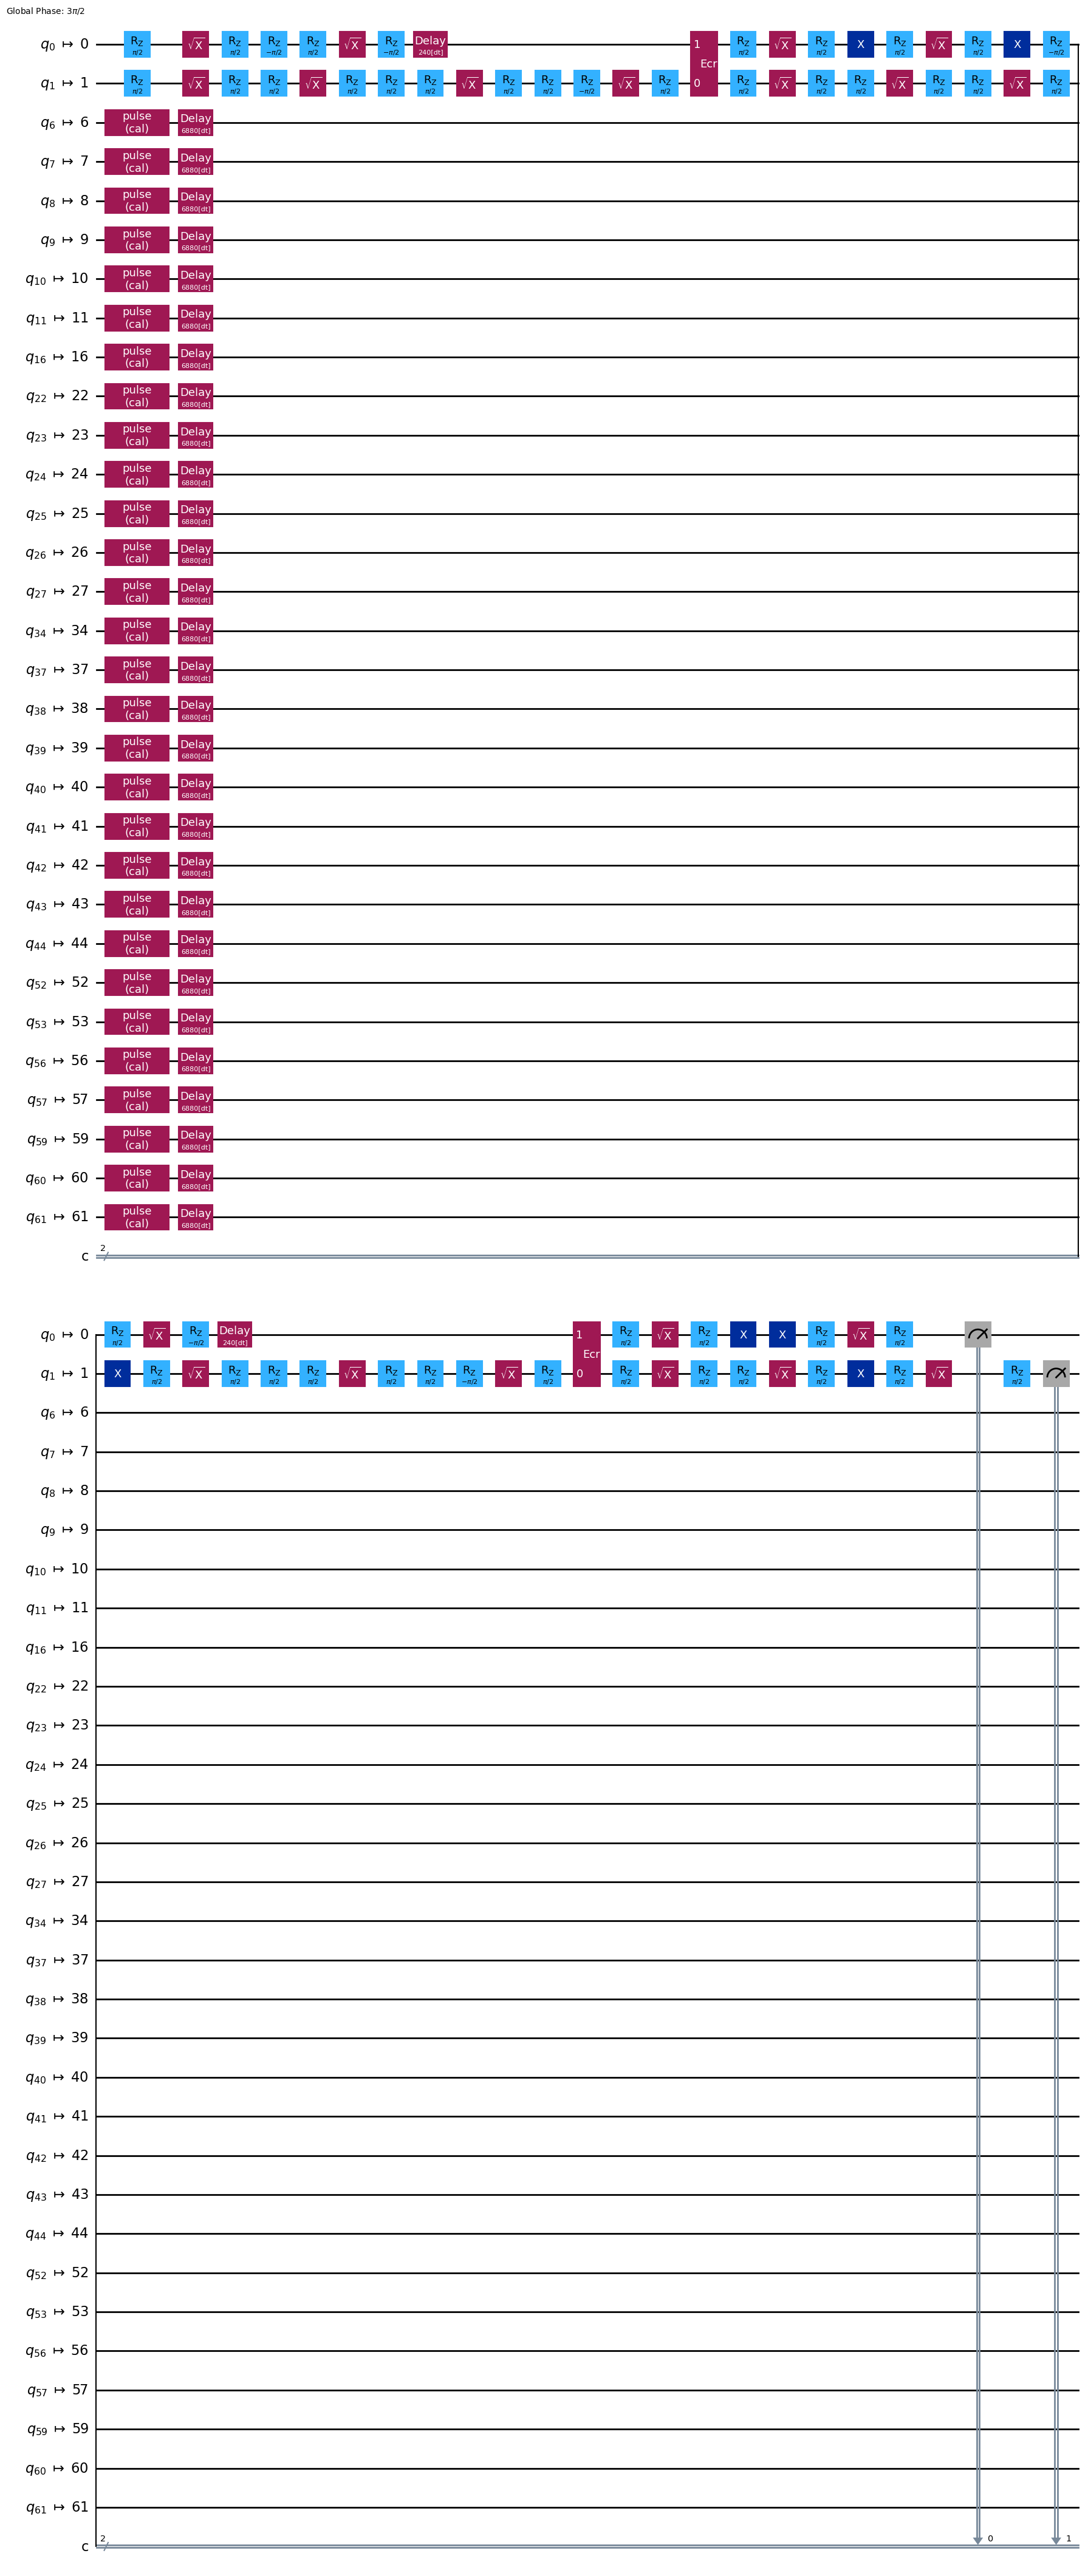

In [14]:
qc = QuantumCircuit(127, 2)

# Grover_n2
qc.h(0)
qc.h(1)
qc.h(1)
qc.cx(0, 1)
qc.h(0)
qc.h(1)
qc.x(0)
qc.h(1)
qc.x(1)
qc.h(1)
qc.cx(0, 1)
qc.h(1)
qc.x(0)
qc.x(1)
qc.h(0)
qc.h(1)

# 29, 6-11
attackers = [39, 6, 22, 40, 23, 38, 7, 8, 24, 37, 41, 34, 9, 42, 16, 52, 53, 25, 10, 43, 56, 26, 60, 59, 11, 44, 57, 27, 61]
attacker = list(set(attackers))
n_attacker = np.size(attacker)

for i in range(n_attacker):
    qc.append(custom_gate, [attacker[i]])
    qc.add_calibration(custom_gate, (attacker[i],), sched, [])

qc.measure(victim, 0)
qc.measure(1, 1)
# qc.draw(idle_wires=False, output = 'mpl')
# qc.draw(idle_wires=False, output = 'mpl', filename='attack.pdf')

qc_tr = transpile(qc, backend, scheduling_method = "asap", layout_method='trivial', optimization_level=0)
qc_tr.draw(idle_wires=False, output = 'mpl')

In [79]:
# qc = QuantumCircuit(127, 3)

# # qaoa_n3
# qc.h(0)
# qc.h(1)
# qc.h(2)
# qc.cx(0, 2)
# qc.rz(pi*1.79986, 2)
# qc.cx(0, 2)
# qc.cx(0, 1)
# qc.cx(1, 2)
# qc.rz(pi*-3.59973, 2)
# qc.cx(1, 2)
# qc.cx(0, 1)
# qc.rx(pi*0.545344, 2)
# qc.rz(pi*-5.39959, 1)
# qc.rx(pi*0.545344, 0)
# qc.rx(pi*0.545344, 1)


# # # 29, 6-11
# attackers = [39, 6, 22, 40, 23, 38, 7, 8, 24, 37, 41, 34, 9, 42, 16, 52, 53, 25, 10, 43, 56, 26, 60, 59, 11, 44, 57, 27, 61]
# attacker = list(set(attackers))
# n_attacker = np.size(attacker)

# for i in range(n_attacker):
#     qc.append(custom_gate, [attacker[i]])
#     qc.add_calibration(custom_gate, (attacker[i],), sched, [])

# qc.measure(victim, 0)
# qc.measure(1, 1)
# qc.measure(2, 2)
# # qc.draw(idle_wires=False, output = 'mpl')
# # qc.draw(idle_wires=False, output = 'mpl', filename='attack.pdf')

# qc_tr = transpile(qc, backend, scheduling_method = "asap", layout_method='trivial', optimization_level=0)
# # qc_tr.draw(idle_wires=False, output = 'mpl')

In [49]:
qc = QuantumCircuit(127, 1)

# for i in range(n_att):
#     qc.append(custom_gate, [attacker[i]])
#     qc.add_calibration(custom_gate, (attacker[i],), sched, [])

for i in range(0,127,1):
    if i == victim:
        qc.measure(victim, 0)
    else:
        qc.append(custom_gate, [i])
        qc.add_calibration(custom_gate, (i,), sched, [])

# attackers = [4, 5, 6, 7, 8, 15, 16, 22, 23, 24, 25, 26]
# attackers = [37, 38, 39, 40, 41, 52, 53, 56, 57, 58, 59, 60]
# attackers = [1, 2, 3, 4, 14, 18, 19, 20, 21, 22]
# attackers = [24, 25, 26, 27, 28, 34, 35, 43, 44, 45, 46, 47]
# 67
# attackers = [1, 14, 2, 18, 19, 3, 4, 20, 33, 21, 5, 15, 39, 6, 22, 40, 23, 38, 7, 8, 24, 37, 41]
# , 34, 9, 42, 16, 52, 53, 25, 10, 43, 56, 26, 60, 59, 11, 44, 57, 27, 61, 12, 45, 58, 28, 62, 35, 71, 72, 13, 46, 17, 54, 29, 63, 64, 77, 47, 81, 30, 65, 76, 78, 48, 80, 82, 31]
# attackers = [34, 9, 42, 16, 52, 53, 25]
## 18, 9-11
# attackers = [34, 9, 42, 16, 52, 53, 25, 10, 43, 56, 26, 60, 59, 11, 44, 57, 27, 61]
# 23, 9-12
# attackers = [34, 9, 42, 16, 52, 53, 25, 10, 43, 56, 26, 60, 59, 11, 44, 57, 27, 61, 12, 45, 58, 28, 62]
# 32, 9-13
# attackers = [34, 9, 42, 16, 52, 53, 25, 10, 43, 56, 26, 60, 59, 11, 44, 57, 27, 61, 12, 45, 58, 28, 62, 35, 71, 72, 13, 46, 17, 54, 29, 63]
# 21, 13-15
# attackers = [35, 71, 72, 13, 46, 17, 54, 29, 63, 64, 77, 47, 81, 30, 65, 76, 78, 48, 80, 82, 31]
# 27, 13-16
# attackers = [35, 71, 72, 13, 46, 17, 54, 29, 63, 64, 77, 47, 81, 30, 65, 76, 78, 48, 80, 82, 31, 32, 66, 75, 79, 49, 83]
# 36, 13-17
# attackers = [35, 71, 72, 13, 46, 17, 54, 29, 63, 64, 77, 47, 81, 30, 65, 76, 78, 48, 80, 82, 31, 32, 66, 75, 79, 49, 83, 67, 36, 73, 50, 84, 55, 90, 91, 92]
# 22, 17-19
# attackers = [67, 36, 73, 50, 84, 55, 90, 91, 92, 98, 68, 102, 51, 85, 94, 97, 99, 69, 101, 103, 86, 95]
# 27, 17-20
# attackers = [67, 36, 73, 50, 84, 55, 90, 91, 92, 98, 68, 102, 51, 85, 94, 97, 99, 69, 101, 103, 86, 95, 96, 100, 70, 104, 87]
# 34, 17-21
# attackers = [67, 36, 73, 50, 84, 55, 90, 91, 92, 98, 68, 102, 51, 85, 94, 97, 99, 69, 101, 103, 86, 95, 96, 100, 70, 104, 87, 105, 74, 109, 110, 111, 88, 93]
# attacker = list(set(attackers))
# n_attacker = np.size(attacker)

# for i in range(n_attacker):
#     qc.append(custom_gate, [attacker[i]])
#     qc.add_calibration(custom_gate, (attacker[i],), sched, [])

# qc.measure(victim, 0)
## target_state = qi.Statevector.from_instruction(qc)

qc_tr = transpile(qc, backend, scheduling_method = "asap", layout_method='trivial', optimization_level=0)
# qc_tr.draw(idle_wires=False, output = 'mpl')

In [51]:
# job = backend.run([qc_tr], 
#                   meas_level=2, 
#                   meas_return='single', 
#                   shots=NUM_SHOTS)
# job_monitor(job)

In [15]:
### all qubit attack, victim = 0
job_id_0 = "ct64gsbykbsg008yjpyg"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "ct64gfs7rgf0008590j0"
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

In [16]:
### all qubit attack, victim = 64
job_id_0 = "ct653sfcvhg0008w9nx0"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "ct64jpawmw20008w4eeg"
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

In [17]:
### all qubit attack, victim = 8
job_id_0 = "ct65630cvhg0008w9p8g"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = ""
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

In [18]:
### all qubit attack, victim = 13
job_id_0 = ""
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "ct657ex3b8m0008bwvg0"
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

KeyError: 'id'

In [ ]:
### all qubit attack, victim = 56
job_id_0 = ""
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = ""
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

In [ ]:
### all qubit attack, victim = 70
job_id_0 = ""
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = ""
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

In [ ]:
### all qubit attack, victim = 113
job_id_0 = ""
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "ct65q6m3b8m0008bwxw0"
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

In [ ]:
### all qubit attack, victim = 118
job_id_0 = ""
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "ct65qw77rgf000859620"
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

In [ ]:
### all qubit attack, victim = 126
job_id_0 = ""
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = ""
job = service.job(job_id_0)
result = job.result()
counts_1 = result.get_counts()

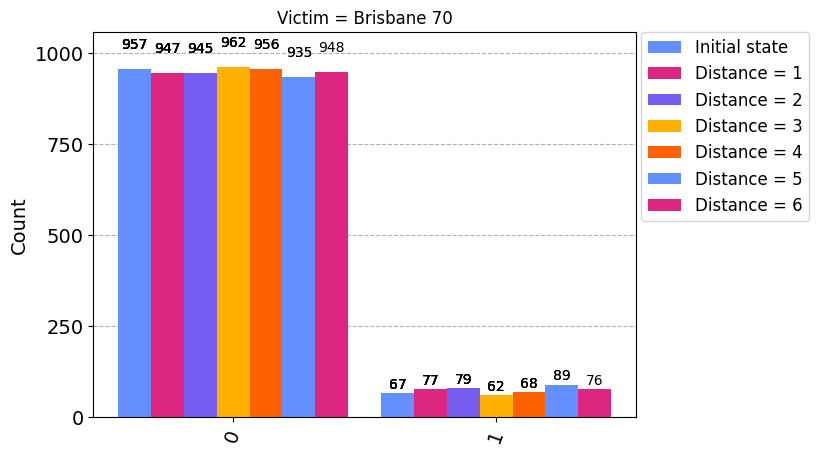

In [ ]:
### victim = 70
job_id_0 = "ct2nrchkmkz000861w50"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "ct2ns7wezpa0008kdjwg"
job = service.job(job_id_1)
result = job.result()
counts_1 = result.get_counts()

job_id_2 = "ct2nsj6kmkz000861wb0"
job = service.job(job_id_2)
result = job.result()
counts_2 = result.get_counts()

job_id_3 = "ct2sqw72tw9g008knqhg"
job = service.job(job_id_3)
result = job.result()
counts_3 = result.get_counts()

job_id_4 = "ct2sr6gkmkz000862teg"
job = service.job(job_id_4)
result = job.result()
counts_4 = result.get_counts()

job_id_5 = "ct2srga8t340008xd4s0"
job = service.job(job_id_5)
result = job.result()
counts_5 = result.get_counts()

job_id_6 = "ct2tmmj8t340008xd8jg"
job = service.job(job_id_6)
result = job.result()
counts_6 = result.get_counts()

plot_histogram([counts_0, counts_1, counts_2, counts_3, counts_4, counts_5, counts_6],
               legend = ['Initial state', 'Distance = 1', 'Distance = 2', 'Distance = 3', 'Distance = 4', 'Distance = 5', 'Distance = 6'],
               title = "Victim = Brisbane 70")


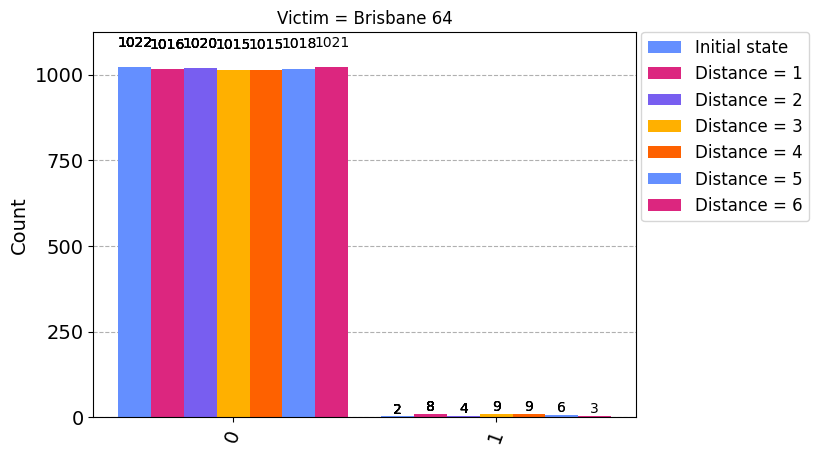

In [ ]:
### victim = 64
job_id_0 = "csr5x9nvwqp0008bxr60"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "csr5wt3vnxy0008e8jc0"
job = service.job(job_id_1)
result = job.result()
counts_1 = result.get_counts()

job_id_2 = "csr5xszvnxy0008e8jn0"
job = service.job(job_id_2)
result = job.result()
counts_2 = result.get_counts()

job_id_3 = "csr5y7gvnxy0008e8jq0"
job = service.job(job_id_3)
result = job.result()
counts_3 = result.get_counts()

job_id_4 = "csr5ygjvnxy0008e8jv0"
job = service.job(job_id_4)
result = job.result()
counts_4 = result.get_counts()

job_id_5 = "csr5yt30c2pg008cww7g"
job = service.job(job_id_5)
result = job.result()
counts_5 = result.get_counts()

job_id_6 = "csr5z3wvwqp0008bxrhg"
job = service.job(job_id_6)
result = job.result()
counts_6 = result.get_counts()

plot_histogram([counts_0, counts_1, counts_2, counts_3, counts_4, counts_5, counts_6],
               legend = ['Initial state', 'Distance = 1', 'Distance = 2', 'Distance = 3', 'Distance = 4', 'Distance = 5', 'Distance = 6'],
               title = "Victim = Brisbane 64")


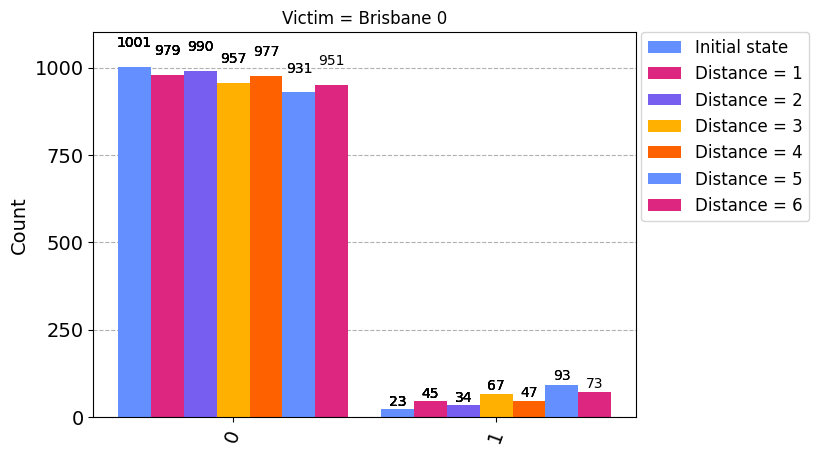

In [ ]:
### victim = 0
job_id_0 = "csr4qqep1vzg008b6p50"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "csr4qanvwqp0008bxjkg"
job = service.job(job_id_1)
result = job.result()
counts_1 = result.get_counts()

job_id_2 = "csr5g30p1vzg008b6svg"
job = service.job(job_id_2)
result = job.result()
counts_2 = result.get_counts()

job_id_3 = "csr5hgevnxy0008e8fpg"
job = service.job(job_id_3)
result = job.result()
counts_3 = result.get_counts()

job_id_4 = "csr5hs7vnxy0008e8fqg"
job = service.job(job_id_4)
result = job.result()
counts_4 = result.get_counts()

job_id_5 = "csr5jw31k2e0008q10y0"
job = service.job(job_id_5)
result = job.result()
counts_5 = result.get_counts()

job_id_6 = "csr5kbdvnxy0008e8g20"
job = service.job(job_id_6)
result = job.result()
counts_6 = result.get_counts()

plot_histogram([counts_0, counts_1, counts_2, counts_3, counts_4, counts_5, counts_6],
               legend = ['Initial state', 'Distance = 1', 'Distance = 2', 'Distance = 3', 'Distance = 4', 'Distance = 5', 'Distance = 6'],
               title = "Victim = Brisbane 0")
